In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df_ori = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/project/data/gdf_final.csv').dropna()
X_col = [
    'dist',
    'delta_time',
    'trip_hour',
    'avgtemp',
    'population_16_with_earnings',
    'median_earnings_(dollars)',
    'median_age_(years)'
]
y_col = ['usage_counts']
classes = ['low', 'mid', 'high']
X = StandardScaler().fit_transform(df_ori[X_col])


In [4]:
from sklearn.ensemble import RandomForestClassifier
y = pd.cut(df_ori[y_col].to_numpy().flatten(), [
           0, 2, 8, 96], labels=classes).tolist()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(criterion='entropy',
                             n_estimators=200, max_features='sqrt', random_state=0)
clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)


(0.9977067342429605, 0.6504293193717278)

In [5]:
from sklearn.ensemble import RandomForestRegressor
y = df_ori[y_col].to_numpy().flatten()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
regr = RandomForestRegressor(criterion='squared_error',
                             n_estimators=200, max_features='sqrt', random_state=0)
regr.fit(X_train, y_train)
regr.score(X_train, y_train), regr.score(X_test, y_test)


(0.953117932935162, 0.6750869599851288)

### use Regression Model

# Evaluate Impurity

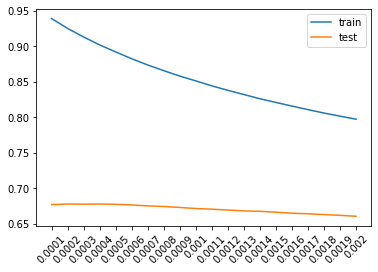

In [6]:
n = 20
test_score_list = np.zeros(n)
train_score_list = np.zeros(n)
decrease_list = [round(i, 6) for i in np.linspace(0.0001, 0.002, n)]
for idx, i in enumerate(decrease_list):
    regr = RandomForestRegressor(min_impurity_decrease=i,
                                 criterion='squared_error', n_estimators=100, random_state=0)
    regr.fit(X_train, y_train)
    train_score_list[idx] = regr.score(X_train, y_train)
    test_score_list[idx] = regr.score(X_test, y_test)
plt.plot(list(range(n)), train_score_list, label='train')
plt.plot(list(range(n)), test_score_list, label='test')
plt.xticks(list(range(n)), decrease_list, rotation=45)
plt.legend()


In [7]:
decrease = decrease_list[np.argmax(test_score_list)]
regr = RandomForestRegressor(min_impurity_decrease=decrease,
                             criterion='squared_error', n_estimators=100, random_state=0)
regr.fit(X_train, y_train)
regr.score(X_train, y_train), regr.score(X_test, y_test)


(0.9251144993990332, 0.6777233594766948)

# Evaluate Max Depth

In [8]:
max([estimator.tree_.max_depth for estimator in regr.estimators_])


43

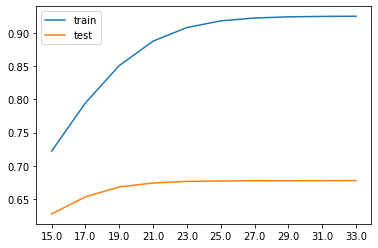

In [9]:
n = 10
train_score_list = np.zeros(n)
test_score_list = np.zeros(n)
depth_list = np.linspace(15, 33, n)
for idx, i in enumerate(depth_list):
    regr = RandomForestRegressor(min_impurity_decrease=decrease, max_depth=i,
                                 criterion='squared_error', n_estimators=100, random_state=0)
    regr.fit(X_train, y_train)
    train_score_list[idx] = regr.score(X_train, y_train)
    test_score_list[idx] = regr.score(X_test, y_test)
plt.plot(list(range(n)), train_score_list, label='train')
plt.plot(list(range(n)), test_score_list, label='test')
plt.xticks(list(range(n)), depth_list)
plt.legend()


In [10]:
depth = 23
regr = RandomForestRegressor(min_impurity_decrease=decrease, max_depth=depth,
                             criterion='squared_error', n_estimators=100, max_features='sqrt', random_state=0)
regr.fit(X_train, y_train)
regr.score(X_train, y_train), regr.score(X_test, y_test)


(0.8586102293466276, 0.6718410603378245)

### Hard to Increase the score through fine tune one parameter

# GridSearch

In [15]:
from sklearn.model_selection import GridSearchCV
parameters = {
    'max_depth': [24, 28, 32, 36, 40],
    'max_features': ['auto', 'sqrt'],
    'min_impurity_decrease': [0.0000001, 0.000001, 0.00001],
    'min_samples_split': [2, 20, 40],
}
regr = RandomForestRegressor(criterion='squared_error', random_state=0)
regr = GridSearchCV(regr, parameters, verbose=2)
regr.fit(X_train, y_train)
regr.score(X_train, y_train), regr.score(X_test, y_test)


Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV] END max_depth=24, max_features=auto, min_impurity_decrease=1e-07, min_samples_split=2; total time=  27.3s
[CV] END max_depth=24, max_features=auto, min_impurity_decrease=1e-07, min_samples_split=2; total time=  27.5s
[CV] END max_depth=24, max_features=auto, min_impurity_decrease=1e-07, min_samples_split=2; total time=  27.8s
[CV] END max_depth=24, max_features=auto, min_impurity_decrease=1e-07, min_samples_split=2; total time=  27.4s
[CV] END max_depth=24, max_features=auto, min_impurity_decrease=1e-07, min_samples_split=2; total time=  27.8s
[CV] END max_depth=24, max_features=auto, min_impurity_decrease=1e-07, min_samples_split=20; total time=  22.3s
[CV] END max_depth=24, max_features=auto, min_impurity_decrease=1e-07, min_samples_split=20; total time=  22.0s
[CV] END max_depth=24, max_features=auto, min_impurity_decrease=1e-07, min_samples_split=20; total time=  22.0s
[CV] END max_depth=24, max_features=auto, min_i

(0.949041069606128, 0.6756212950879839)

In [19]:
regr.best_params_['max_depth']
regr.best_params_['min_impurity_decrease']


{'max_depth': 28,
 'max_features': 'auto',
 'min_impurity_decrease': 1e-05,
 'min_samples_split': 2}

In [20]:
regr = RandomForestRegressor(min_impurity_decrease=regr.best_params_['min_impurity_decrease'],
                             max_depth=regr.best_params_['max_depth'],
                             max_features=regr.best_params_['max_features'],
                             oob_score=True,
                             n_estimators=500,
                             criterion='squared_error',
                             random_state=0)
regr.fit(X, y)
regr.oob_score_


0.6922354614250437